# Simple Phase Classifier

Predict the [phase](https://clinicaltrials.gov/ct2/help/phase_desc) from the pubmed abstract of a clinical trial

In [ ]:
from cochranenlp.readers import biviewer

ct_biviewer = biviewer.ClinicalTrialsBiViewer()

### Extract `(abstract, phase)` Pairs

In [8]:
from collections import namedtuple

BiView = namedtuple('BiView', ['abstract', 'phase'])

def abstracts_and_phases_generator():
    for study in ct_biviewer:
        yield BiView(study.pubmed.text_all()['abstract'], study.clinicaltrials.phase)
        
biviews = [biview for biview in abstracts_and_phases_generator()]

df = pd.DataFrame(biviews, columns=BiView._fields)

### Word Clouds for Each Phase

In [65]:
import wordcloud

def word_cloud(words, axes, title):
    wc = wordcloud.WordCloud().generate(words)
    axes.imshow(wc)
    axes.axis('off')
    plt.title(title)

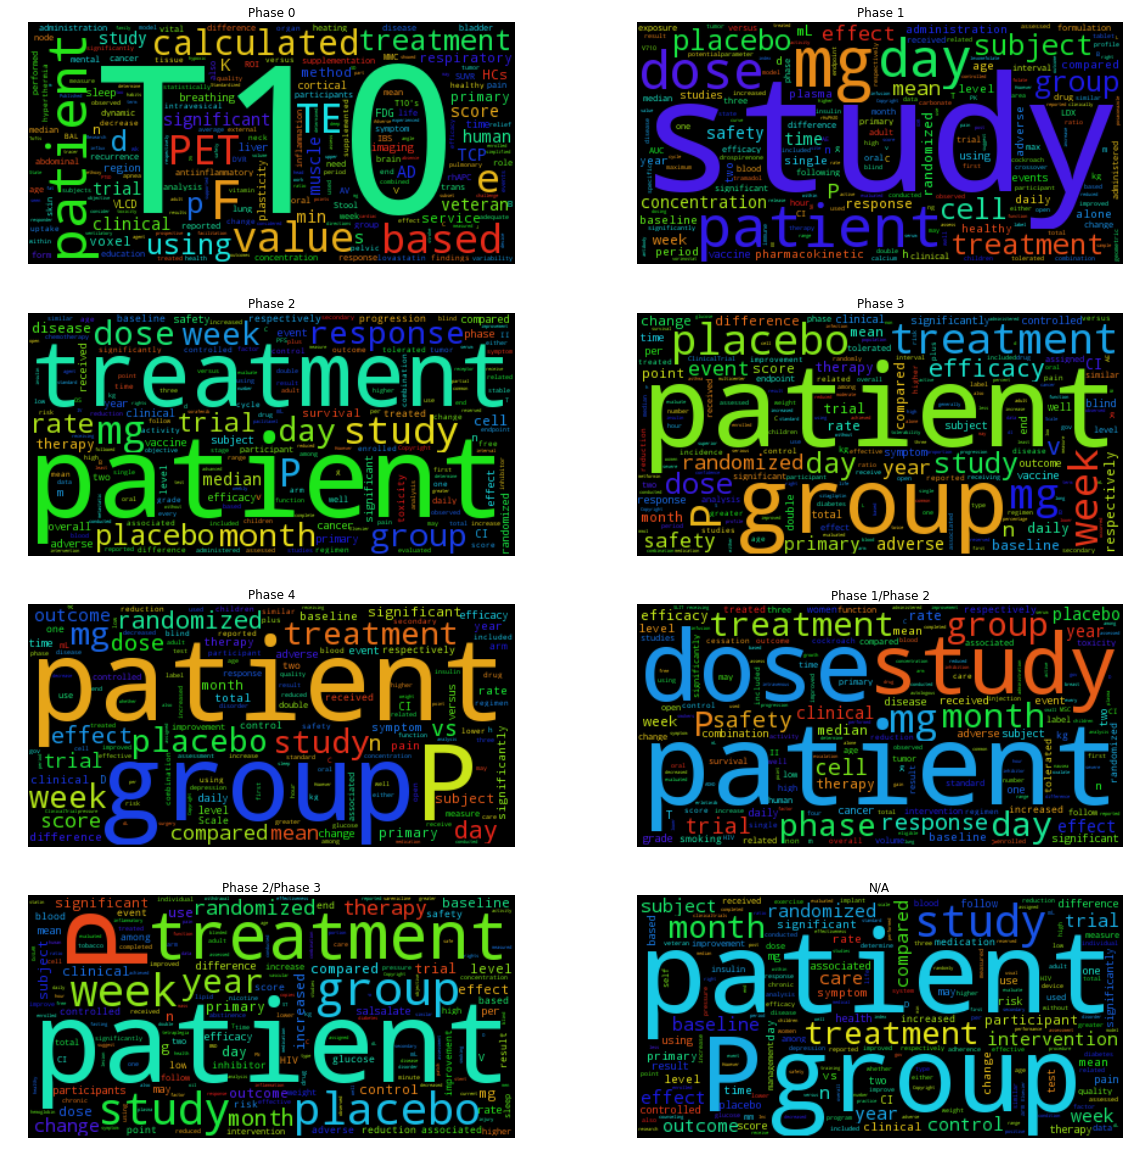

In [66]:
fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, phase in enumerate(phases, start=1):
    axes = fig.add_subplot(4, 2, i)
    words = ' '.join(df[df.phase == phase].abstract)
    
    word_cloud(words, axes, phase)
    
plt.axis('off')
plt.show()

### Map Classes to Binary Labels

In [12]:
phases = ['Phase 0', 'Phase 1', 'Phase 2', 'Phase 3', 'Phase 4', 'Phase 1/Phase 2', 'Phase 2/Phase 3', 'N/A']

phase_map = {phase:i for i, phase in enumerate(phases)}

df['label'] = df.phase.map(phase_map)

### Fit and Transform

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df.abstract)

X.shape

(2127, 18232)

### Train Test Split

In [46]:
from sklearn.cross_validation import train_test_split

X_train, X_test, ys_train, ys_test = train_test_split(X, df.label)

### Train

In [47]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1e5, class_weight='balanced', multi_class='multinomial', solver='lbfgs')

logreg.fit(X_train, ys_train)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0)

### Prediction

In [49]:
import sklearn

predictions = logreg.predict(X_test)

sklearn.metrics.f1_score(ys_test, predictions)

/home/ebanner/.anaconda/envs/py27/lib/python2.7/site-packages/sklearn/metrics/classification.py:676: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.48908534257082764

### Confusion Matrix

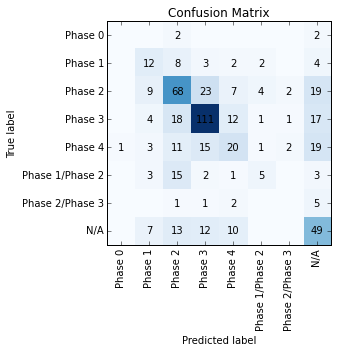

In [52]:
confusion_matrix = sklearn.metrics.confusion_matrix(ys_test, predictions)

fig = plt.figure()
plt.clf()

plt.imshow(confusion_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion Matrix')
tick_marks = np.arange(len(phases))
plt.xticks(tick_marks, phases, rotation=90)
plt.yticks(tick_marks, phases)
plt.ylabel('True label')
plt.xlabel('Predicted label')

width = height = len(phases)

for x in xrange(width):
    for y in xrange(height):
        plt.annotate(str(confusion_matrix[x][y]) if confusion_matrix[x][y] else '', xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

### Features with Highest Coefficients

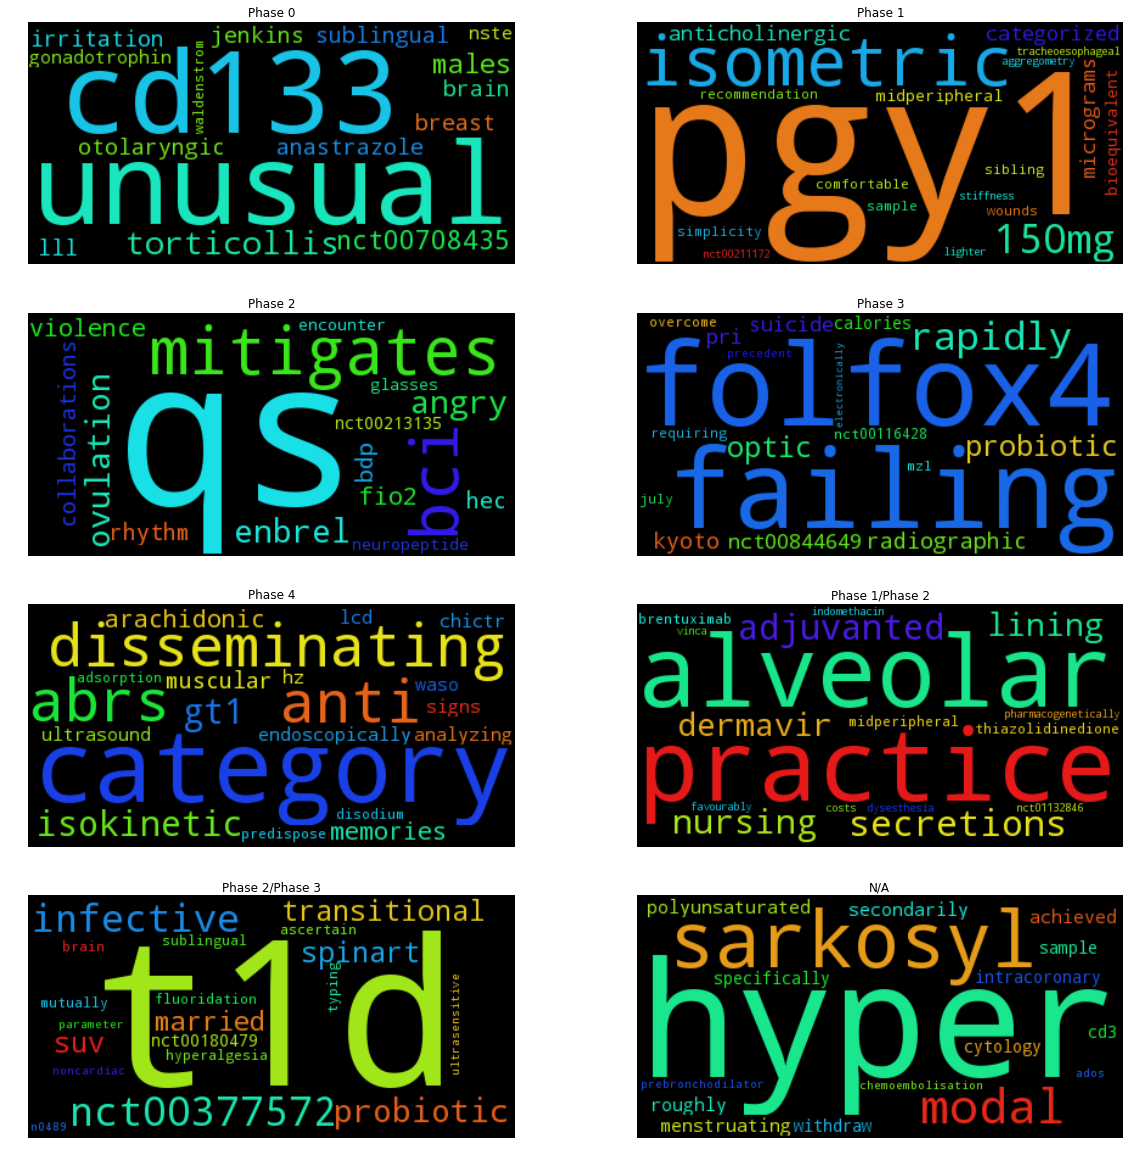

In [57]:
fig = plt.figure(figsize=(20, 20))
plt.clf()

for i, (weights, title) in enumerate(zip(logreg.coef_, phases), start=1):
    words = sorted(zip(weights, vectorizer.vocabulary_), reverse=True)[:20]
    words = ' '.join(word[1] for word in words)
    
    axes = fig.add_subplot(4, 2, i)
    word_cloud(words, axes, title)
    
plt.axis('off')
plt.show()